## Knock Out Rules optimisation through NGSA II

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  
import kooptimize.NGSAII as ngsa2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('data/train_fin_cols.csv')
#test = pd.read_csv('data/test_fin_cols.csv')

#Train on a random sub sample, as it takes time.
train = train.sample(50000)

y = train['loan_default']

#test_unique_id = test['uniqueid']
#test_unique_id = test_unique_id.reset_index()

train = train.drop(['loan_default'],axis=1)

print("Loaded train data with shape {}".format(train.shape))
print("Loaded train target with shape {}".format(y.shape))
#print("Loaded test target with shape {}".format(test.shape))

categorical_columns_to_drop = ['uniqueid','branch_id','supplier_id','manufacturer_id','current_pincode_id',
                               'state_id','employee_code_id','perform_cns_score_description','employment_type','state_hrg','emp_hrg',
                              'branch_hrg','pincode_hrg','supplier_hrg','manf_hrg']
categorical_columns = ['employment_type','perform_cns_score_description']

train = train.drop(categorical_columns_to_drop,axis=1)
#test = test.drop(categorical_columns_to_drop,axis=1)

Loaded train data with shape (50000, 58)
Loaded train target with shape (50000,)


When all KO rules are applied :

In [3]:
individual = [1,1,1,1,1,1,1,1,1,1]
selected_rules = ngsa2.get_rules_for_individual(individual)
X_ko,y_ko = ngsa2.apply_rules_to_df(train,y,selected_rules)
print("Application with all KO rules : {}".format(X_ko.shape[0]))

Application with all KO rules : 16650


In [4]:
import time
start_time = time.time()
feature_list =[1]*10
print("AUC with All features  : {} ".format(ngsa2.get_cv_score(X_ko,y_ko,feature_list)))
chromosome_length = len(feature_list)
print("No.of KO Rules : {}".format(chromosome_length))
print("Time Taken : {} s".format(time.time()-start_time))

AUC with All features  : 62.000809564459445 
No.of KO Rules : 10
Time Taken : 7.318009853363037 s


Generation 0 out of 10 


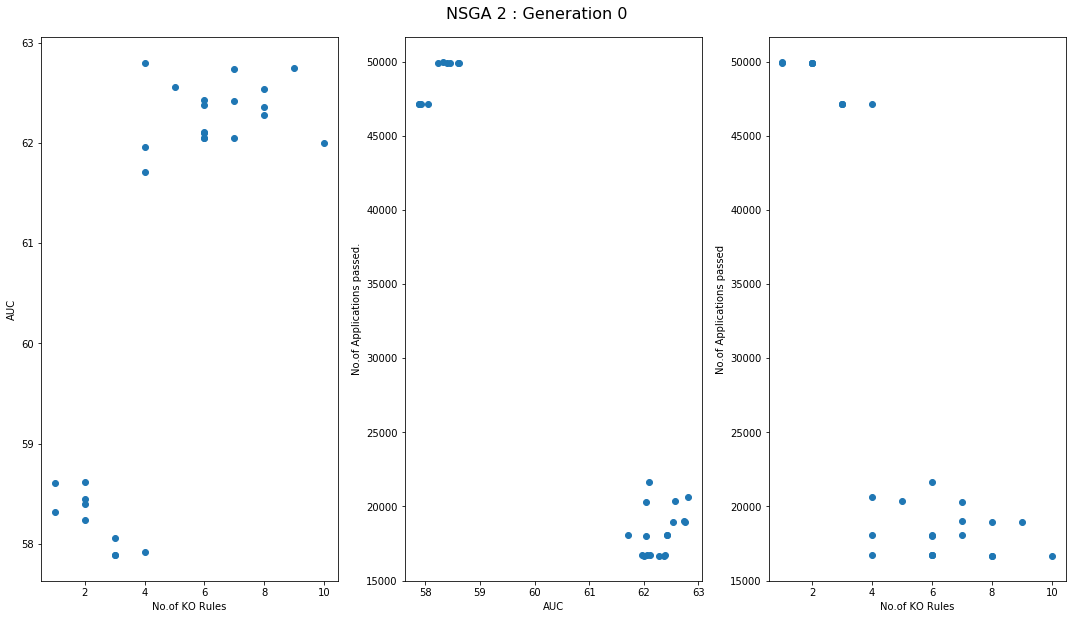

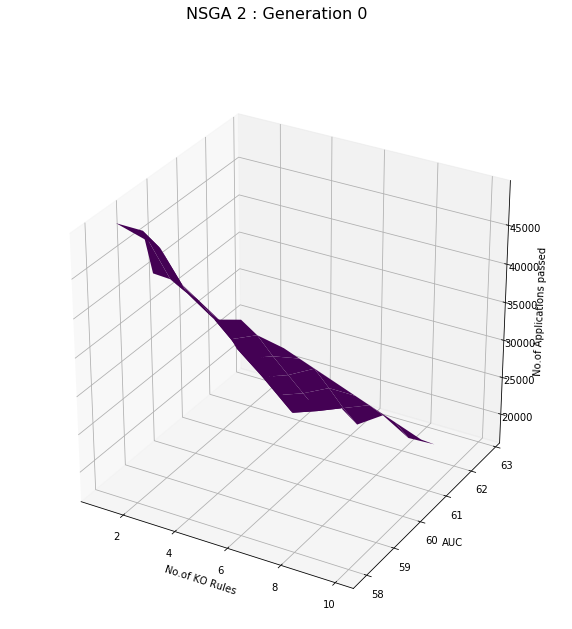

371.5721731185913 secs for Generation 0 


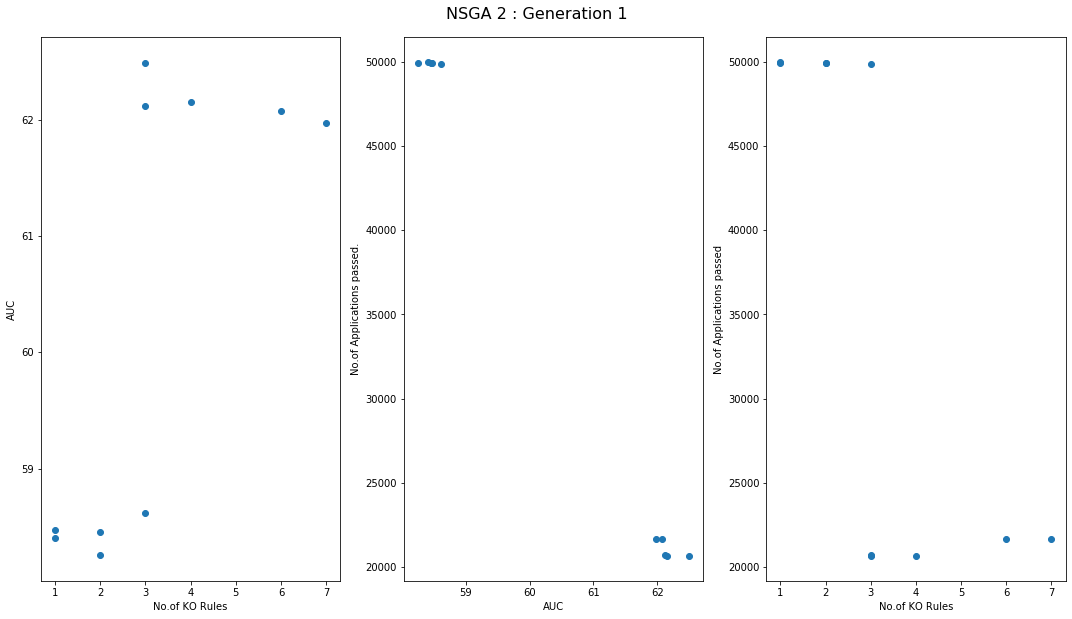

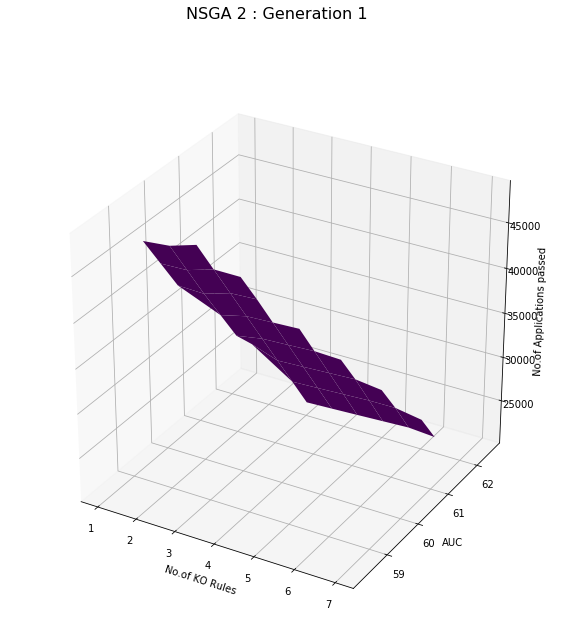

165.52644991874695 secs for Generation 1 


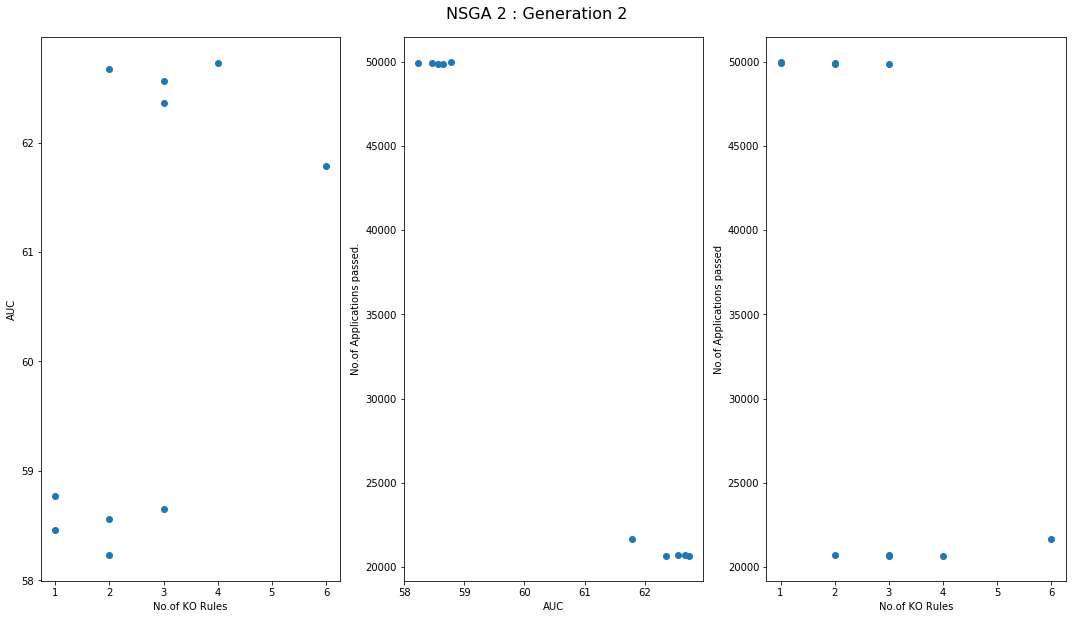

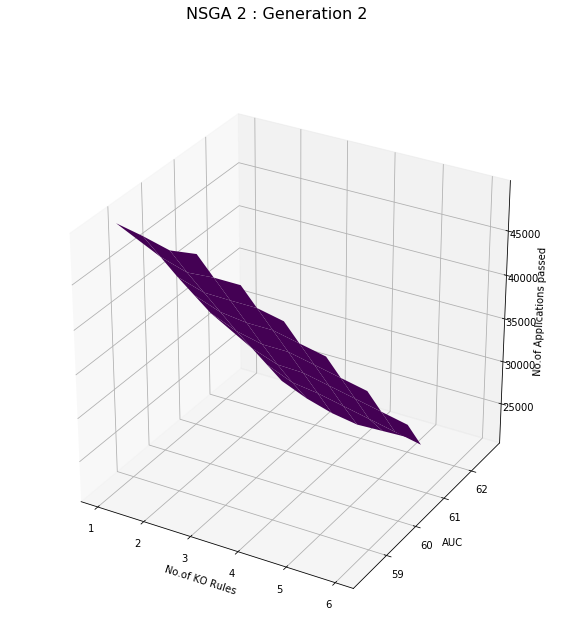

163.1129608154297 secs for Generation 2 


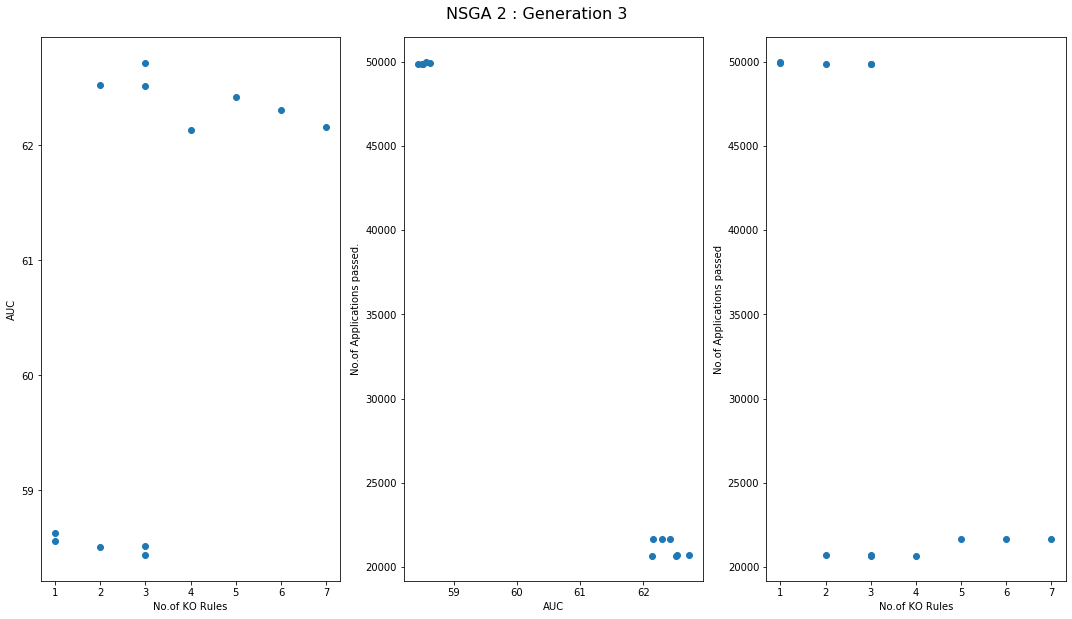

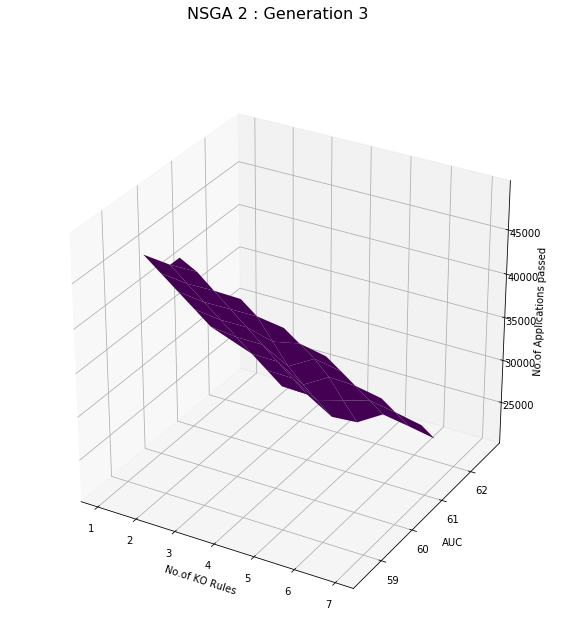

188.16896319389343 secs for Generation 3 


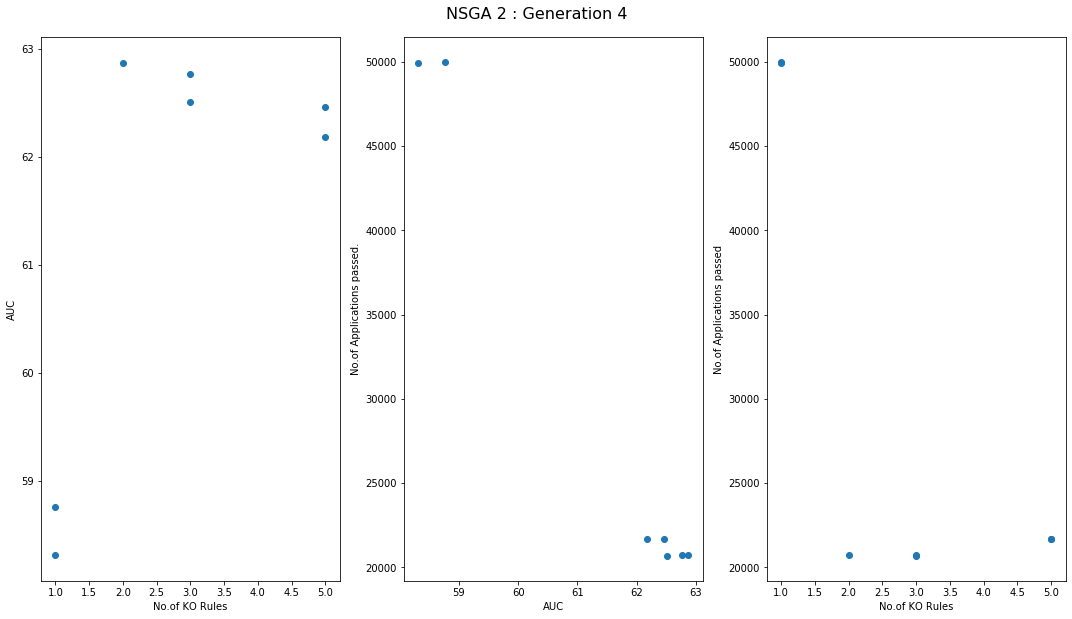

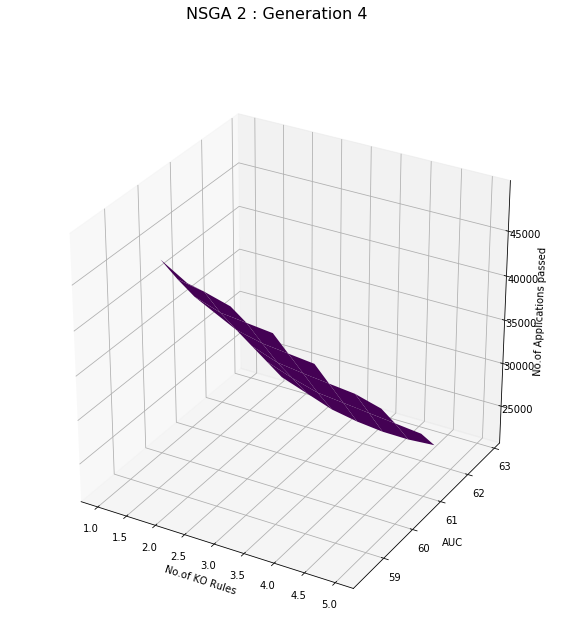

93.71563911437988 secs for Generation 4 


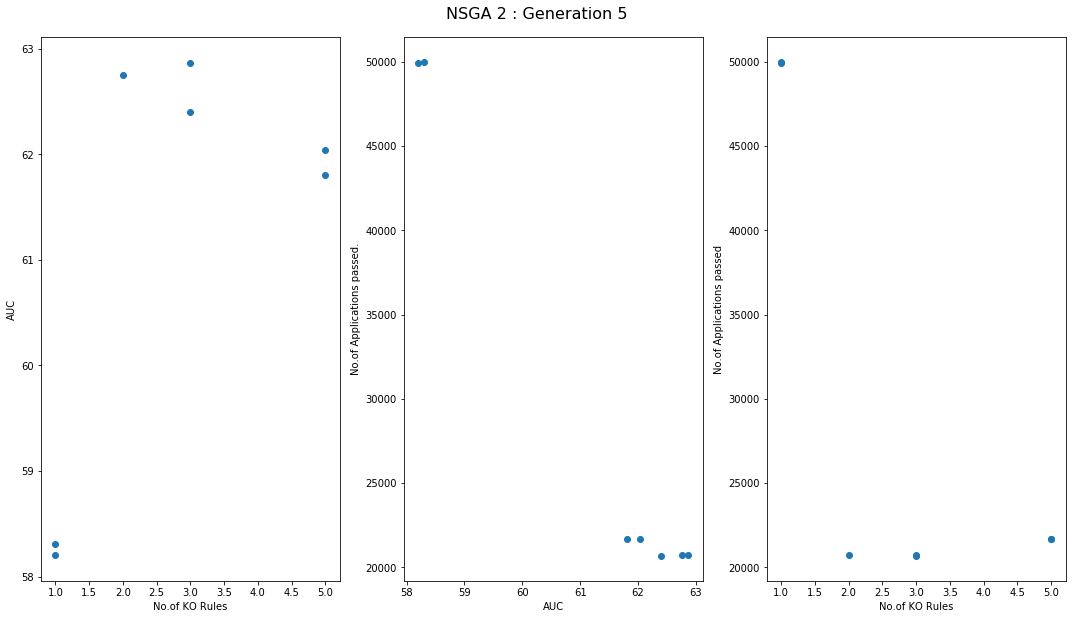

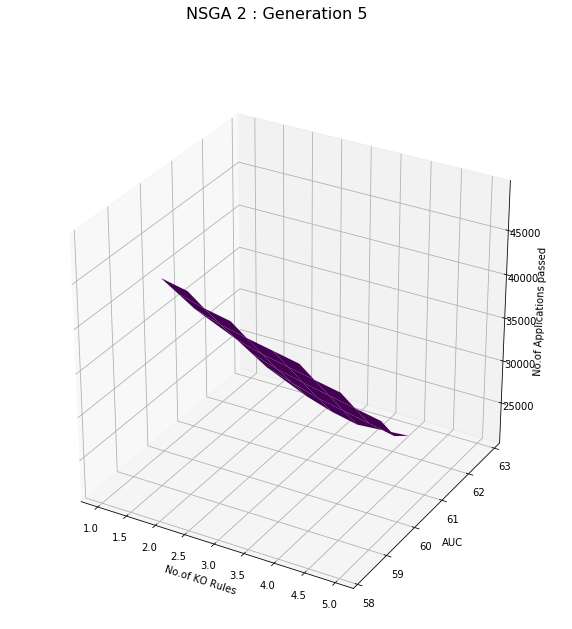

96.07521986961365 secs for Generation 5 


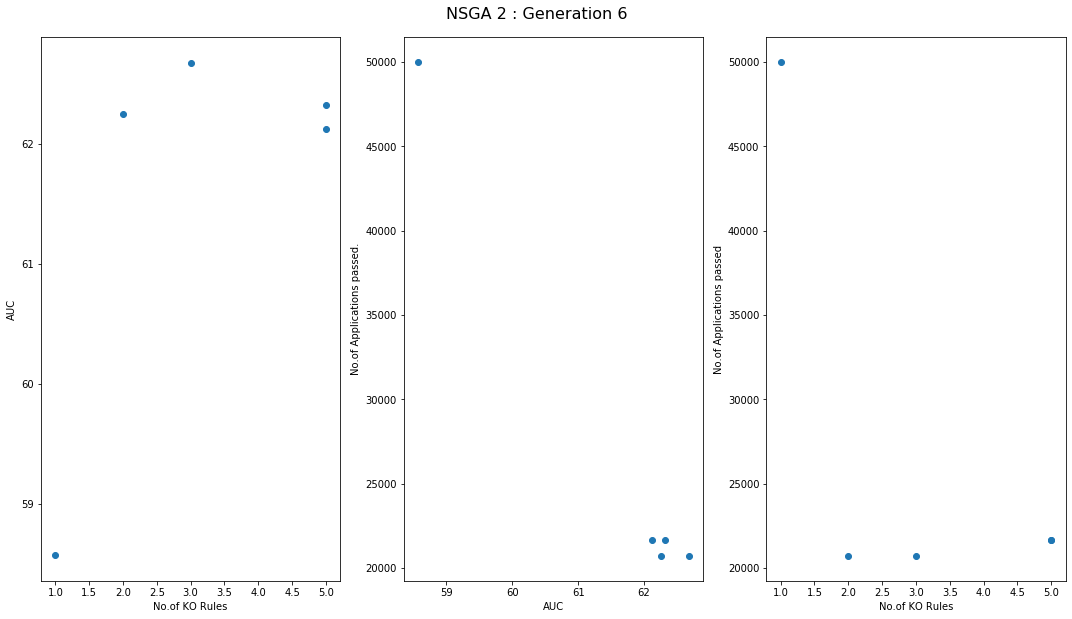

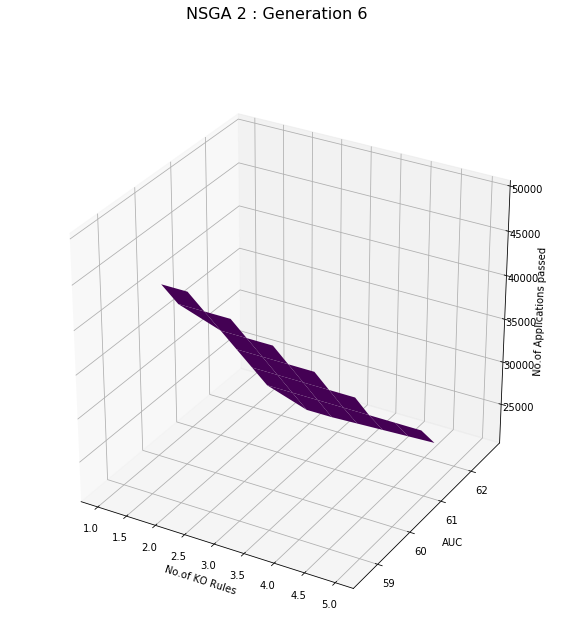

61.00402092933655 secs for Generation 6 


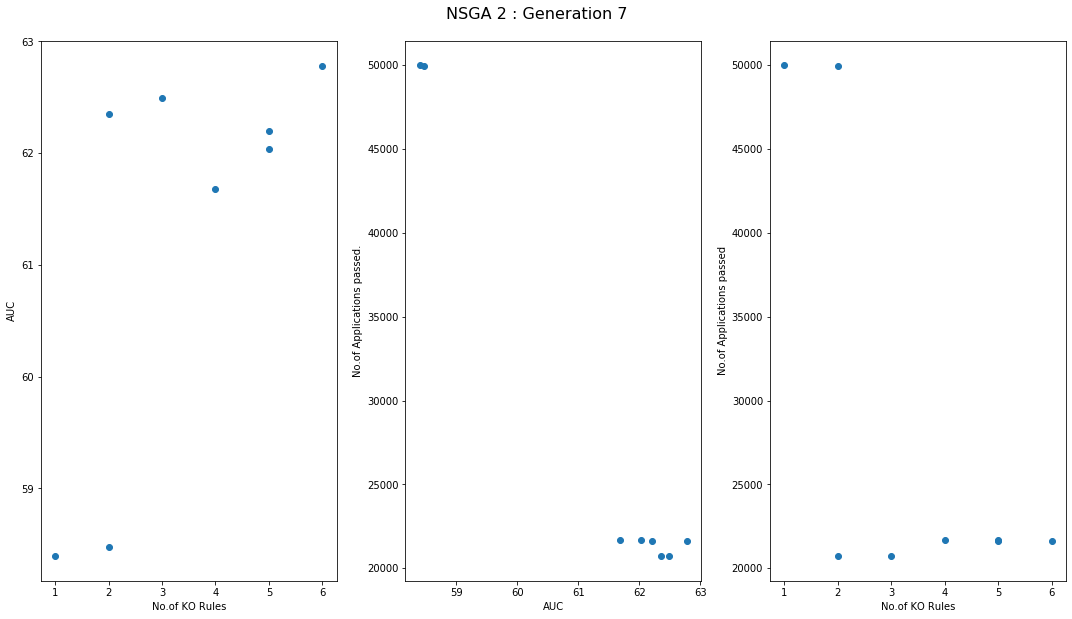

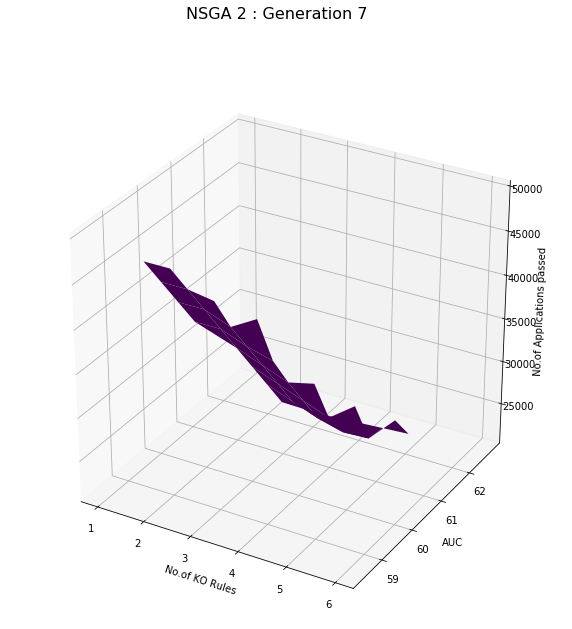

104.43507814407349 secs for Generation 7 


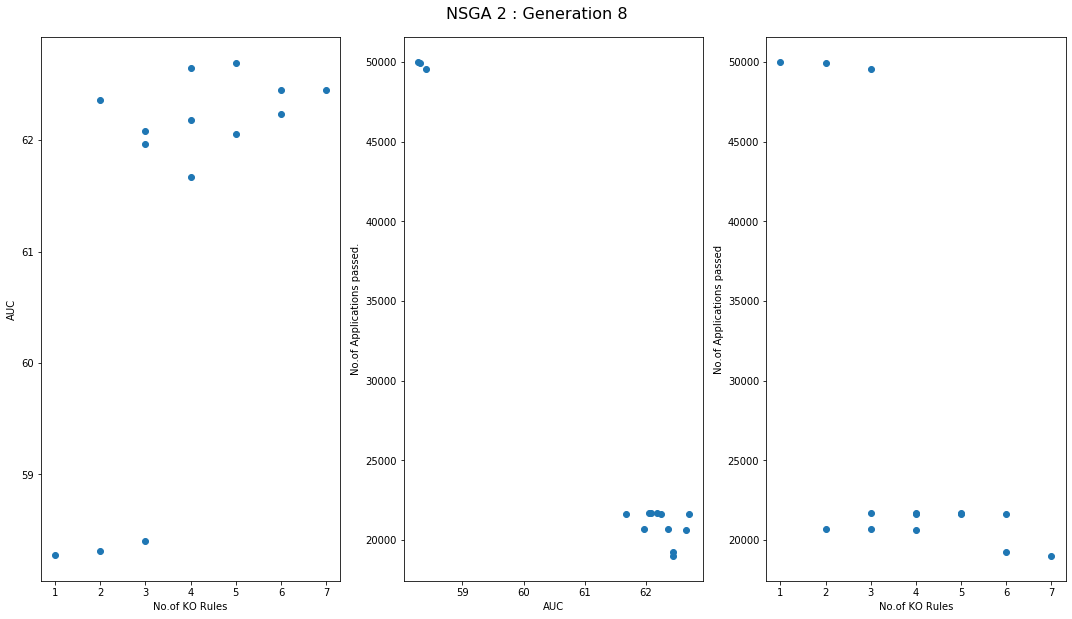

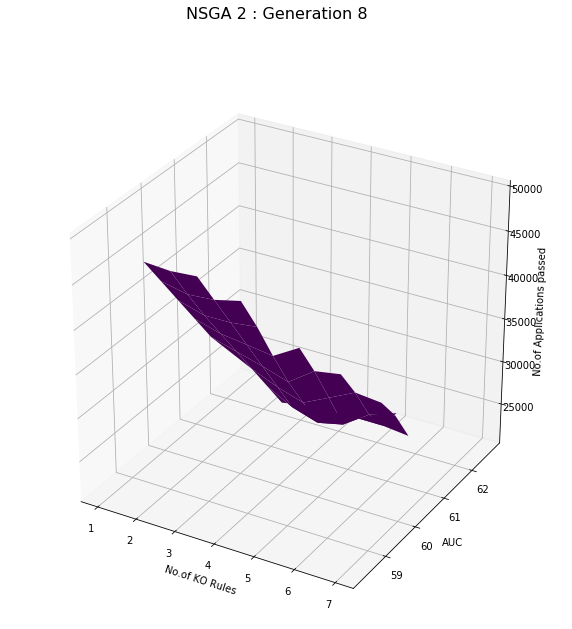

172.07208108901978 secs for Generation 8 


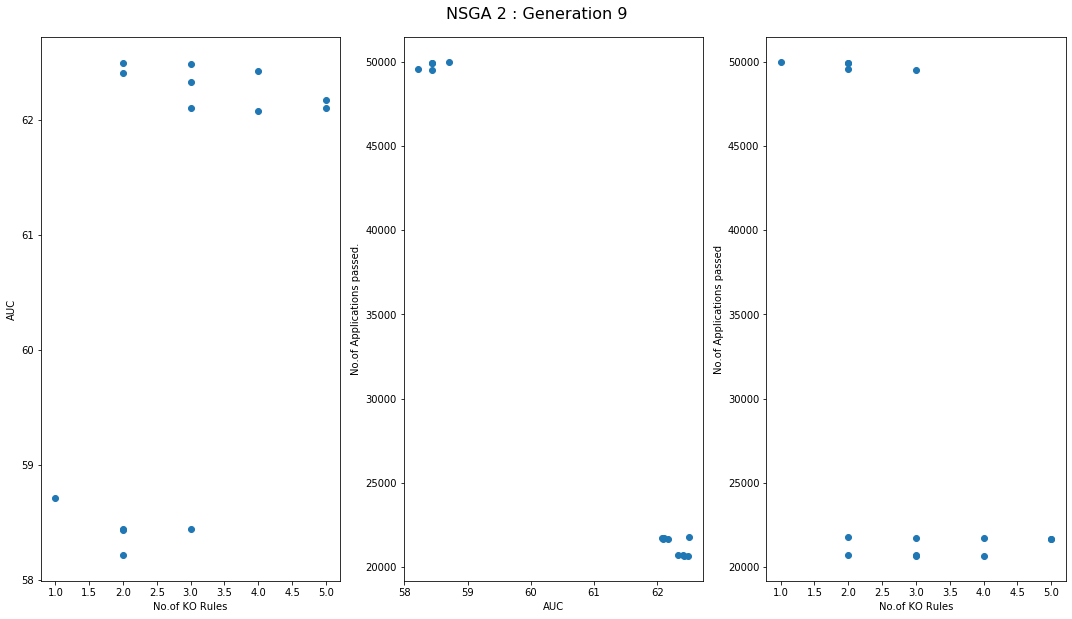

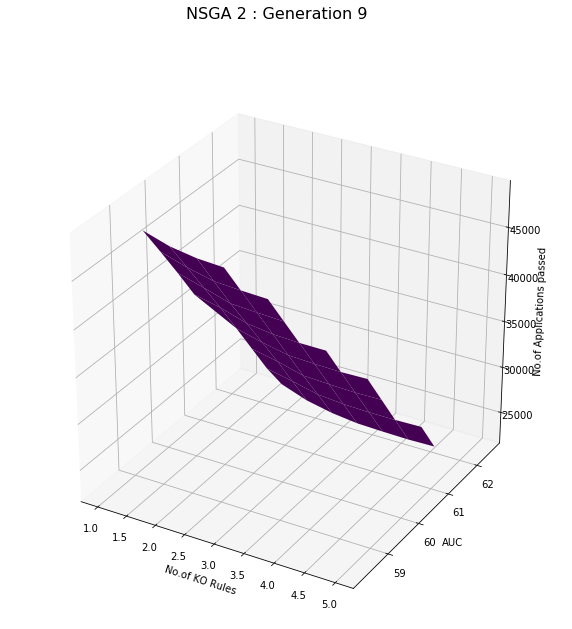

200.85589504241943 secs for Generation 9 


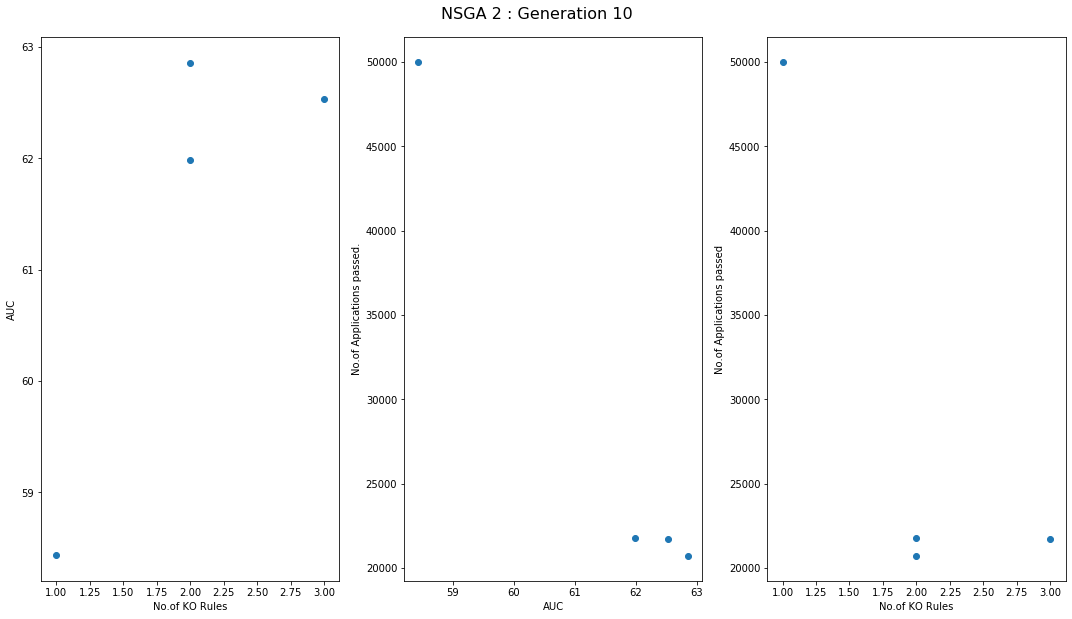

[Text(0, 0.5, 'Time(secs)'), Text(0.5, 0, 'Generations')]

Text(0.5, 1.0, 'Time required per Generation.')

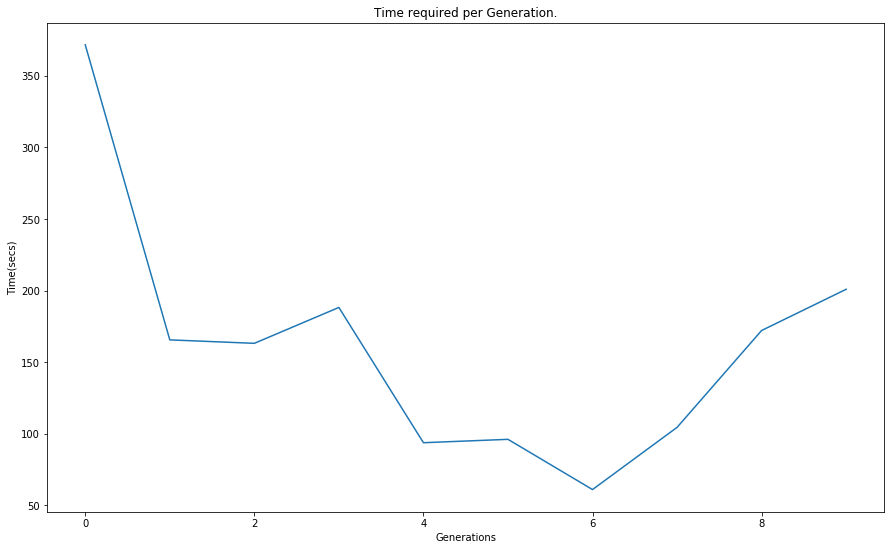

In [5]:
# Set general parameters
starting_population_size = 20
maximum_generation = 10
minimum_population_size = 5
maximum_population_size = 10

# Create starting population
population = ngsa2.create_population(starting_population_size,chromosome_length)
population = np.unique(population, axis=0)
# Now we'll go through the generations of genetic algorithm

generation_list = []
time_required = []

for generation in range(maximum_generation):
    start_time = time.time()
    
    if generation %10 == 0:
        print ('Generation {} out of {} '.format(generation,maximum_generation))
    
    # Breed
    population = ngsa2.breed_population(population)
    
    # Score population
    population,scores = ngsa2.score_population(train,y,population)
    
    
    # Build pareto front
    population = ngsa2.build_pareto_population(
            population, scores, minimum_population_size, maximum_population_size)
    
    ngsa2.plot_2d_paretofront(scores,generation)
    ngsa2.plot_3d_paretofront(scores,generation)
    
    time_taken = time.time()-start_time
    print("{} secs for Generation {} ".format(time_taken,generation))
    
    generation_list.append(generation)
    time_required.append(time_taken)
    

# Get final pareto front
population,scores = ngsa2.score_population(train,y,population)
population_ids = np.arange(population.shape[0]).astype(int)
pareto_front = ngsa2.identify_pareto(scores, population_ids)
population = population[pareto_front, :]
scores = scores[pareto_front]

#Selected Population
#print("Selected Population : \n",population)
#print("Scores", scores)
ngsa2.plot_2d_paretofront(scores,generation+1)
#ngsa2.plot_3d_paretofront(scores,generation+1)

#Plot time taken for calculation.
fig,ax = plt.subplots()
ax.plot(generation_list,time_required)
ax.set(xlabel="Generations",ylabel="Time(secs)")
ax.set_title('Time required per Generation.')
fig.show()

### Final Results

In [6]:
ngsa2.show_population_score_df(population,scores)

,#Rules,AUC,No.ofApplications,Rules
0,2.0,61.981991,21770.0,"{7.0: 'new_accts_in_last_six_months <= 4', 8.0: 'perform_cns_score >= 250'}"
1,1.0,58.434712,50000.0,{1.0: 'age_when_disbursal <= 840 '}
2,2.0,62.859075,20718.0,"{5.0: 'sec_no_of_accts <= 15', 6.0: 'avg_acct_age_m >= 6'}"
3,3.0,62.528196,21725.0,"{3.0: 'delinquent_accts_in_last_six_months <=3', 7.0: 'new_accts_in_last_six_months <= 4', 8.0: 'perform_cns_score >= 250'}"
